In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Temporal Network Edgelist using Arxiv Dataset
In order to convert an edgelist into a temporal edgelist, add a datetime field of some sort that you can group on. Depending on use-case, you may want this down to the minute or second. These are research papers, so I will do down to the YEARMONTH.

In [3]:
data = 'data/arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title', 'date_published']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

# make ready for temporal network analysis
df.sort_values('date_published', inplace=True)
df['date_published'] = pd.to_datetime(df['date_published'])
df['date_published'] = df['date_published'].dt.strftime('%Y%m')

df.head()

,authors,title,date_published
7188,Mark M. Millonas,"Swarms, Phase Transitions, and Collective Inte...",199306
7187,Kunihiko Kaneko,Chaos as a Source of Complexity and Diversity ...,199311
7186,Chris Adami,On Modelling Life,199405
7185,C. Titus Brown,Evolutionary Learning in the 2D Artificial Lif...,199405
7184,Chris Adami,Evolutionary Learning in the 2D Artificial Lif...,199405


# Visual Spot Check of Titles Per Year
This will give us some understanding of the patterns in this dataset.

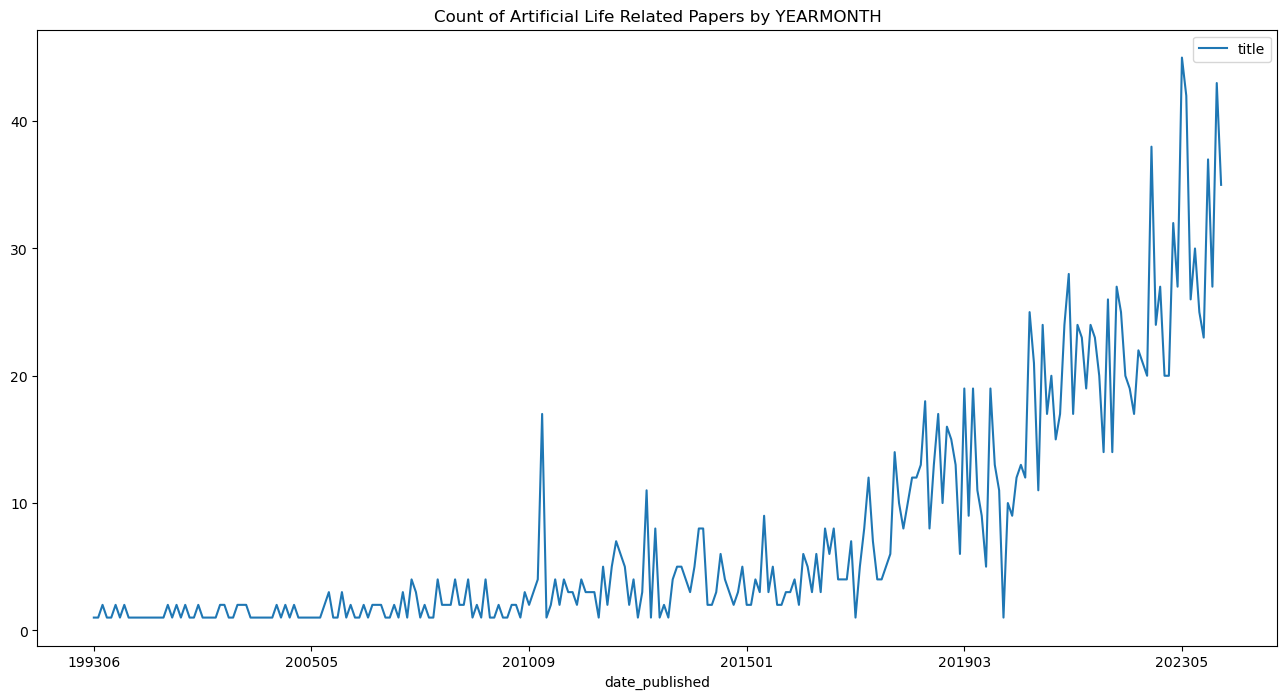

In [4]:
check_df = df[['title', 'date_published']].copy()
check_df.drop_duplicates(inplace=True)

title = 'Count of Artificial Life Related Papers by YEARMONTH'
_= check_df.groupby('date_published').count()[:-1].plot(figsize=(16,8), title=title)

# Create Dictionary of Temporal Graphs using Bipartite Projection
Using Bipartite Projectin, I can convert this mixed network into a social network, which we can explore. This requires some coding.

We explored "Network Changes" on day 13.

In [5]:
# I will use a dictionary of temporal graphs

G = {}

In [6]:
# Psuedocode

# For each YEARMONTH in df
    # Add a temporal social network to the dictionary
    
# This takes a few minutes on a large network; There is probably a way to speed this up, with some thought.

In [7]:
from networkx.algorithms import bipartite
from tqdm import tqdm

dates = sorted(set(df['date_published']))

for i in tqdm(range(len(dates))):
        
    date = dates[i]
        
    network_df = df[df['date_published']==date].copy()
    
    if network_df.shape[1] > 2:
        
        G[date] = {}
        B = nx.from_pandas_edgelist(network_df, source='authors', target='title')
        G[date]['graph'] = bipartite.projected_graph(B, network_df['authors'])

        #G[date] = nx.k_core(G[date], 2) # no isolates or two-node groups

100%|███████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 341.72it/s]


In [8]:
list(G.keys())[-10:]

['202306',
 '202307',
 '202308',
 '202309',
 '202310',
 '202311',
 '202312',
 '202401',
 '202402',
 '202403']

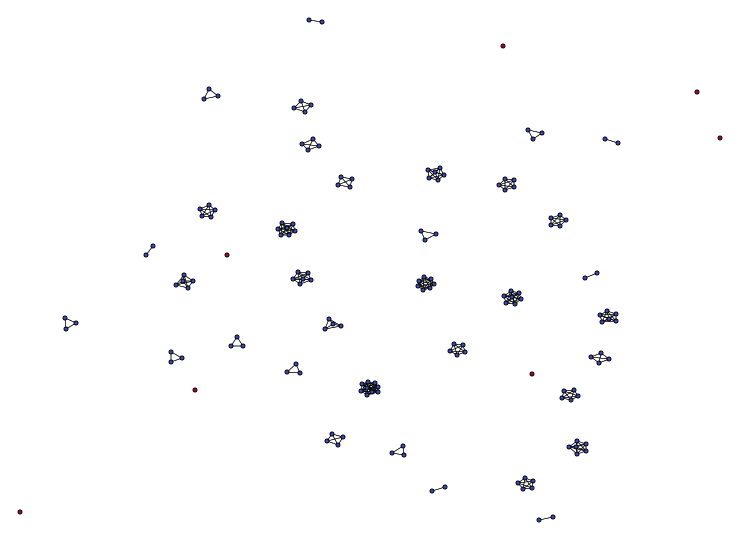

In [9]:
draw_graph(G['202306']['graph'], show_names=False, node_size=2)

# Enrich the Graph Data

In [10]:
def enrich_temporal_graph(G):
    
    i = 0
    
    G = G.copy()
            
    for key in list(G.keys()):
                
        cur_idx = list(G.keys())[i]
        
        if i > 0:
            prev_idx = i - 1
            prev_idx = list(G.keys())[prev_idx]
        else:
            prev_idx = list(G.keys())[0]
                
        if key == list(G.keys())[0]: # if first element
            G[cur_idx]['density_change'] = nx.density(G[cur_idx]['graph'])
            G[cur_idx]['degree_change'] = len(G[cur_idx]['graph'].degree)
            G[cur_idx]['edge_change'] = len(G[cur_idx]['graph'].edges)
            continue
            
        current_edges = list(G[cur_idx]['graph'].edges)
        previous_edges = list(G[prev_idx]['graph'].edges)

        current_nodes = list(G[cur_idx]['graph'].nodes)
        previous_nodes = list(G[prev_idx]['graph'].nodes)

        # edge changes
        dropped_edges = sorted([e for e in previous_edges if e not in current_edges])
        added_edges = sorted([e for e in current_edges if e not in previous_edges])
        G[cur_idx]['dropped_edges'] = dropped_edges
        G[cur_idx]['added_edges'] = added_edges

        # node changes
        dropped_nodes = sorted([n for n in previous_nodes if n not in current_nodes])
        added_nodes = sorted([n for n in current_nodes if n not in previous_nodes])
        G[cur_idx]['dropped_nodes'] = dropped_nodes
        G[cur_idx]['dropped_node_count'] = len(dropped_nodes)
        G[cur_idx]['added_nodes'] = added_nodes
        G[cur_idx]['added_node_count'] = len(added_nodes)

        # dropped parts of Graph
        G_dropped = nx.from_edgelist(dropped_edges)
        G[cur_idx]['graph_dropped'] = G_dropped

        # added parts of Graph
        G_added = nx.from_edgelist(added_edges)
        G[cur_idx]['graph_added'] = G_added

        # changes to density (could use any "Whole Network Analysis" metrics, or centralities, etc; get creative)
        density_change = nx.density(G[cur_idx]['graph']) - nx.density(G[prev_idx]['graph'])
        degree_change = len(G[cur_idx]['graph'].degree) - len(G[prev_idx]['graph'].degree)
        edge_change = len(G[cur_idx]['graph'].edges) - len(G[prev_idx]['graph'].edges)
        G[cur_idx]['density_change'] = density_change
        G[cur_idx]['degree_change'] = degree_change
        G[cur_idx]['edge_change'] = edge_change
        
        # get the core
        max_degrees = max([d[1] for d in G[cur_idx]['graph'].degree])
        cutoff_threshold=2 # for k_core; subjective
        k = max_degrees - cutoff_threshold
        
        G[cur_idx]['graph_core'] = nx.k_core(G[cur_idx]['graph'], k)
        G[cur_idx]['graph_core_node_count'] = len(G[cur_idx]['graph_core'].nodes)
        G[cur_idx]['graph_core_edge_count'] = len(G[cur_idx]['graph_core'].edges)

        i += 1
        
    return G

In [11]:
G = enrich_temporal_graph(G)

In [19]:
list(G.keys())[10:15]

['199807', '199809', '199812', '199901', '199903']

In [20]:
G['199807']

{'graph': <networkx.classes.graph.Graph at 0x24cdfa32dd0>,
 'dropped_edges': [('Robel Yirdaw', 'Chris Adami'),
  ('Robel Yirdaw', 'Ryoichi Seki'),
  ('Ryoichi Seki', 'Chris Adami')],
 'added_edges': [('Christoph Adami', 'Jens C. Astor')],
 'dropped_nodes': ['Chris Adami', 'Robel Yirdaw', 'Ryoichi Seki'],
 'dropped_node_count': 3,
 'added_nodes': ['Christoph Adami', 'Jens C. Astor'],
 'added_node_count': 2,
 'graph_dropped': <networkx.classes.graph.Graph at 0x24ce03c5690>,
 'graph_added': <networkx.classes.graph.Graph at 0x24ce03c5f10>,
 'density_change': 0.0,
 'degree_change': -1,
 'edge_change': -2,
 'graph_core': <networkx.classes.graph.Graph at 0x24ce03c6450>,
 'graph_core_node_count': 2,
 'graph_core_edge_count': 1}

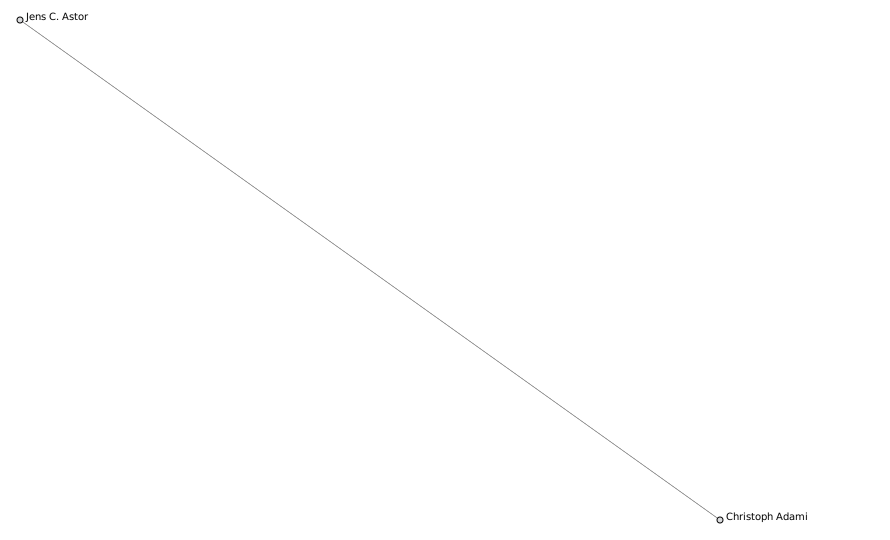

In [21]:
draw_graph(G['199807']['graph'], show_names=True, node_size=3)

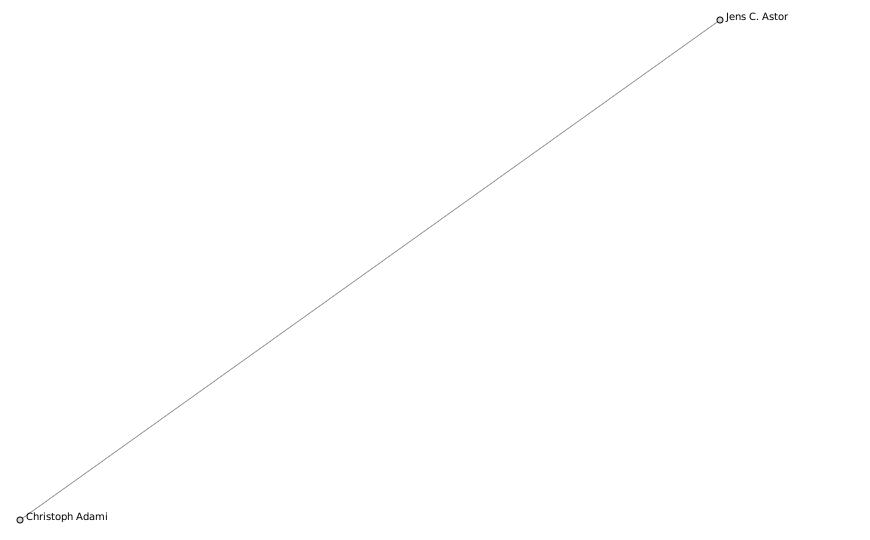

In [22]:
draw_graph(G['199807']['graph_core'], show_names=True, node_size=3)

# Burstiness By Node Count

In [23]:
result_df = pd.DataFrame(G).T

result_df.head()

,graph,density_change,degree_change,edge_change,dropped_edges,added_edges,dropped_nodes,dropped_node_count,added_nodes,added_node_count,graph_dropped,graph_added,graph_core,graph_core_node_count,graph_core_edge_count
199306,(Mark M. Millonas),0,0,0,[],[],[],0,[],0,(),(),(Mark M. Millonas),1,0
199311,(Kunihiko Kaneko),0,0,0,[],[],[Mark M. Millonas],1,[Kunihiko Kaneko],1,(),(),(Kunihiko Kaneko),1,0
199405,"(Chris Adami, C. Titus Brown)",1.0,1,1,[],"[(Chris Adami, C. Titus Brown)]",[Kunihiko Kaneko],1,"[C. Titus Brown, Chris Adami]",2,(),"(Chris Adami, C. Titus Brown)","(Chris Adami, C. Titus Brown)",2,1
199412,"(Dan Ashlock, Leigh Tesfatsion, E. Ann Stanley...",0.0,2,5,"[(Chris Adami, C. Titus Brown)]","[(Dan Ashlock, E. Ann Stanley), (Dan Ashlock, ...","[C. Titus Brown, Chris Adami]",2,"[Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...",4,"(Chris Adami, C. Titus Brown)","(Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...","(Dan Ashlock, Leigh Tesfatsion, E. Ann Stanley...",4,6
199503,"(C. T. Brown, M. Haggerty, C. Adami)",0.0,-1,-3,"[(Dan Ashlock, E. Ann Stanley), (Dan Ashlock, ...","[(C. T. Brown, C. Adami), (C. T. Brown, M. Hag...","[Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...",4,"[C. Adami, C. T. Brown, M. Haggerty]",3,"(Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...","(C. T. Brown, C. Adami, M. Haggerty)","(C. T. Brown, M. Haggerty, C. Adami)",3,3


In [24]:
result_df[result_df['added_node_count'] > 800].index.values[-20:] # just a nonsense threshold to experiment

array([], dtype=object)

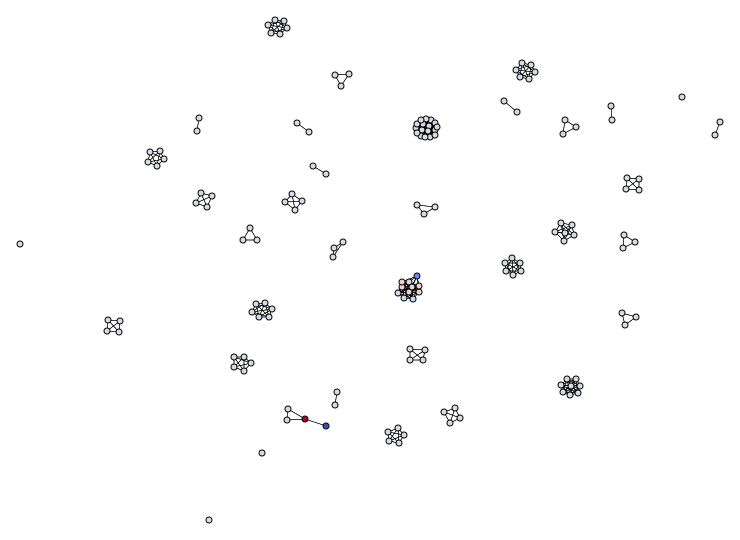

In [25]:
draw_graph(G['202210']['graph'], show_names=False, node_size=3)

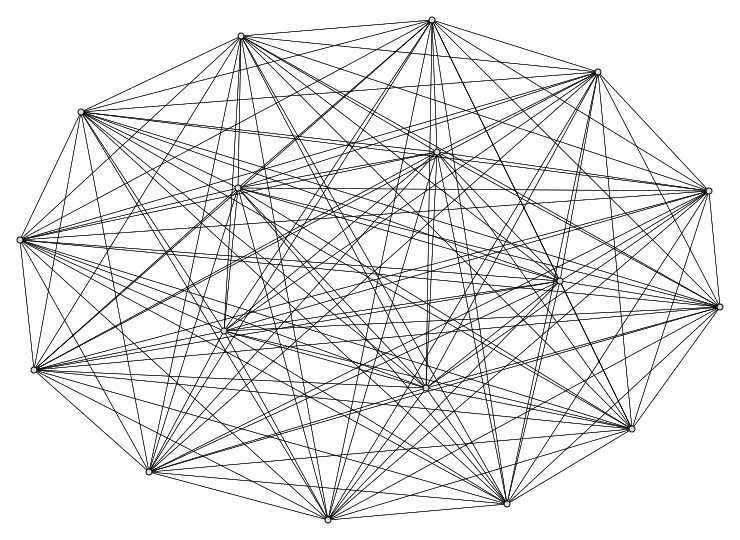

In [26]:
draw_graph(G['202210']['graph_core'], show_names=False, node_size=3)

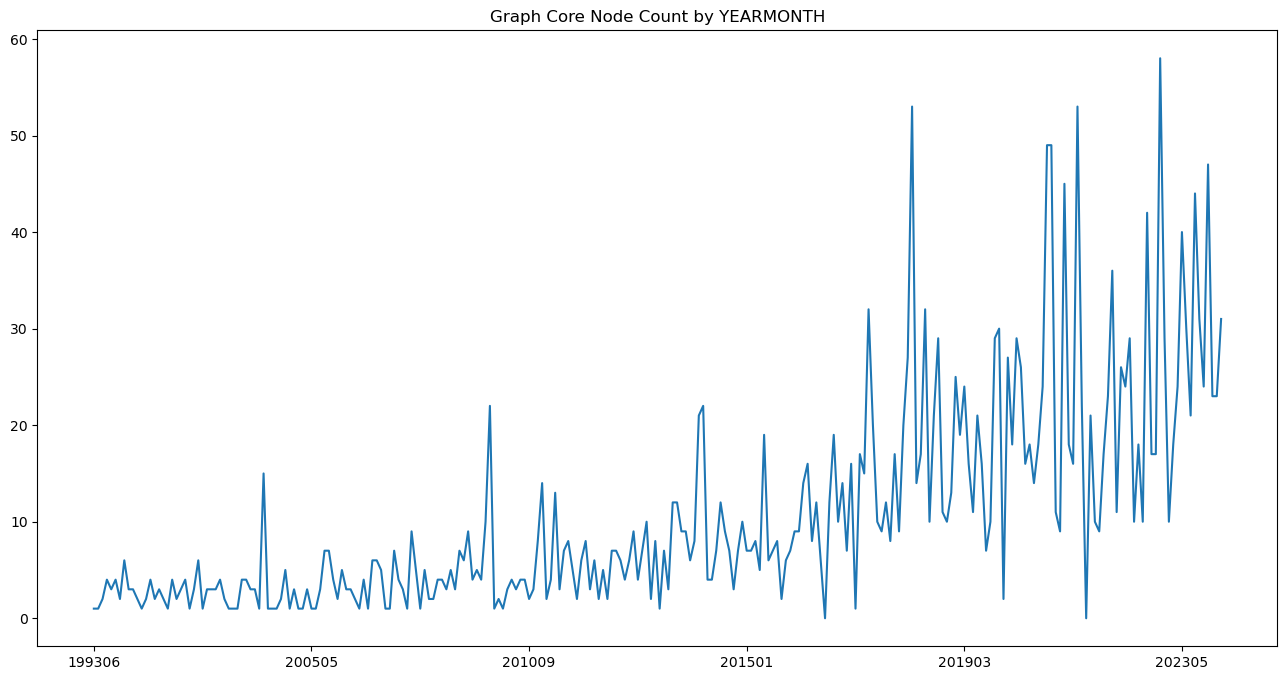

In [27]:
title = 'Graph Core Node Count by YEARMONTH'

_= result_df['graph_core_node_count'].plot(figsize=(16, 8), title=title)

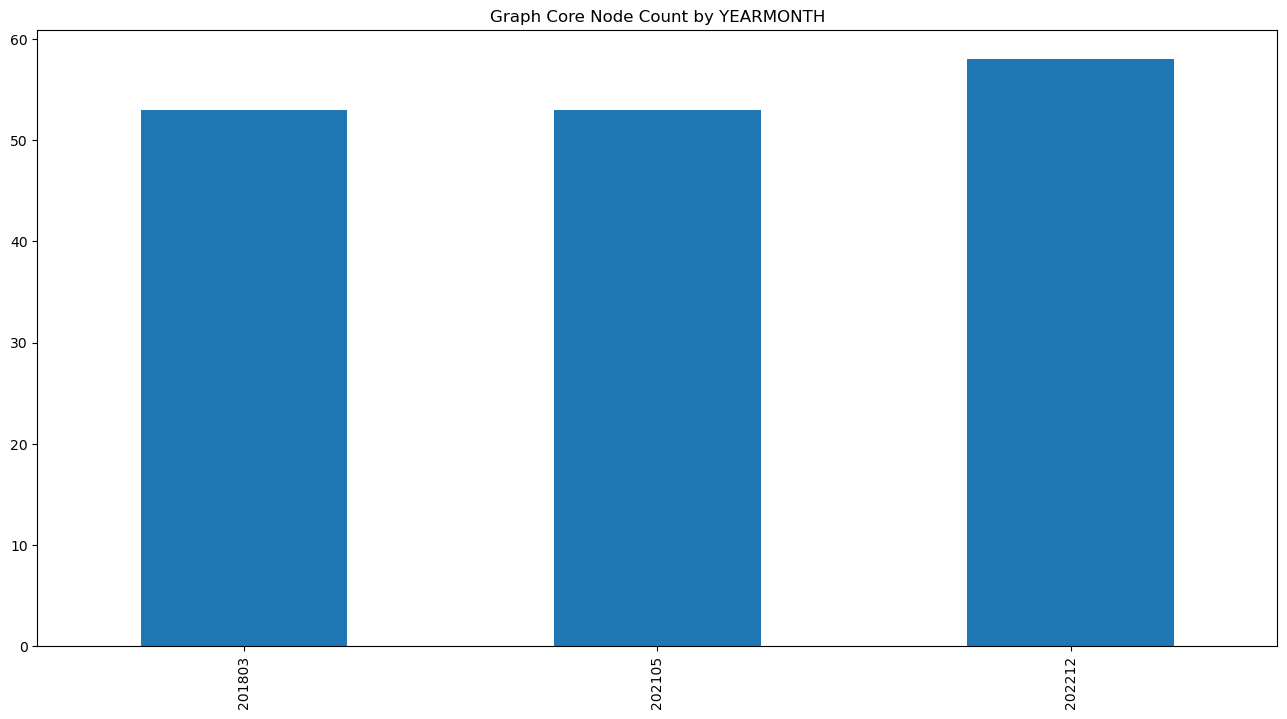

In [28]:
threshold = 50

result_df = result_df[result_df['graph_core_node_count']>threshold]

title = 'Graph Core Node Count by YEARMONTH'

_= result_df['graph_core_node_count'].plot.bar(figsize=(16, 8), title=title)

# Burstiness By Density Increase (EVERYBODY ARRIVED)

In [29]:
result_df = pd.DataFrame(G).T

result_df.head()

,graph,density_change,degree_change,edge_change,dropped_edges,added_edges,dropped_nodes,dropped_node_count,added_nodes,added_node_count,graph_dropped,graph_added,graph_core,graph_core_node_count,graph_core_edge_count
199306,(Mark M. Millonas),0,0,0,[],[],[],0,[],0,(),(),(Mark M. Millonas),1,0
199311,(Kunihiko Kaneko),0,0,0,[],[],[Mark M. Millonas],1,[Kunihiko Kaneko],1,(),(),(Kunihiko Kaneko),1,0
199405,"(Chris Adami, C. Titus Brown)",1.0,1,1,[],"[(Chris Adami, C. Titus Brown)]",[Kunihiko Kaneko],1,"[C. Titus Brown, Chris Adami]",2,(),"(Chris Adami, C. Titus Brown)","(Chris Adami, C. Titus Brown)",2,1
199412,"(Dan Ashlock, Leigh Tesfatsion, E. Ann Stanley...",0.0,2,5,"[(Chris Adami, C. Titus Brown)]","[(Dan Ashlock, E. Ann Stanley), (Dan Ashlock, ...","[C. Titus Brown, Chris Adami]",2,"[Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...",4,"(Chris Adami, C. Titus Brown)","(Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...","(Dan Ashlock, Leigh Tesfatsion, E. Ann Stanley...",4,6
199503,"(C. T. Brown, M. Haggerty, C. Adami)",0.0,-1,-3,"[(Dan Ashlock, E. Ann Stanley), (Dan Ashlock, ...","[(C. T. Brown, C. Adami), (C. T. Brown, M. Hag...","[Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...",4,"[C. Adami, C. T. Brown, M. Haggerty]",3,"(Dan Ashlock, E. Ann Stanley, Leigh Tesfatsion...","(C. T. Brown, C. Adami, M. Haggerty)","(C. T. Brown, M. Haggerty, C. Adami)",3,3


In [30]:
result_df['density_change'][-20:] #small bug to fix on the last one, for another day

202208    0.004062
202209     0.00129
202210   -0.016415
202211    0.019208
202212   -0.020195
202301    0.013713
202302    0.008748
202303   -0.022344
202304    0.012128
202305   -0.023335
202306    0.000808
202307    0.019669
202308   -0.004585
202309    0.001826
202310    0.000926
202311   -0.000407
202312    0.017956
202401   -0.029995
202402    0.002569
202403         NaN
Name: density_change, dtype: object

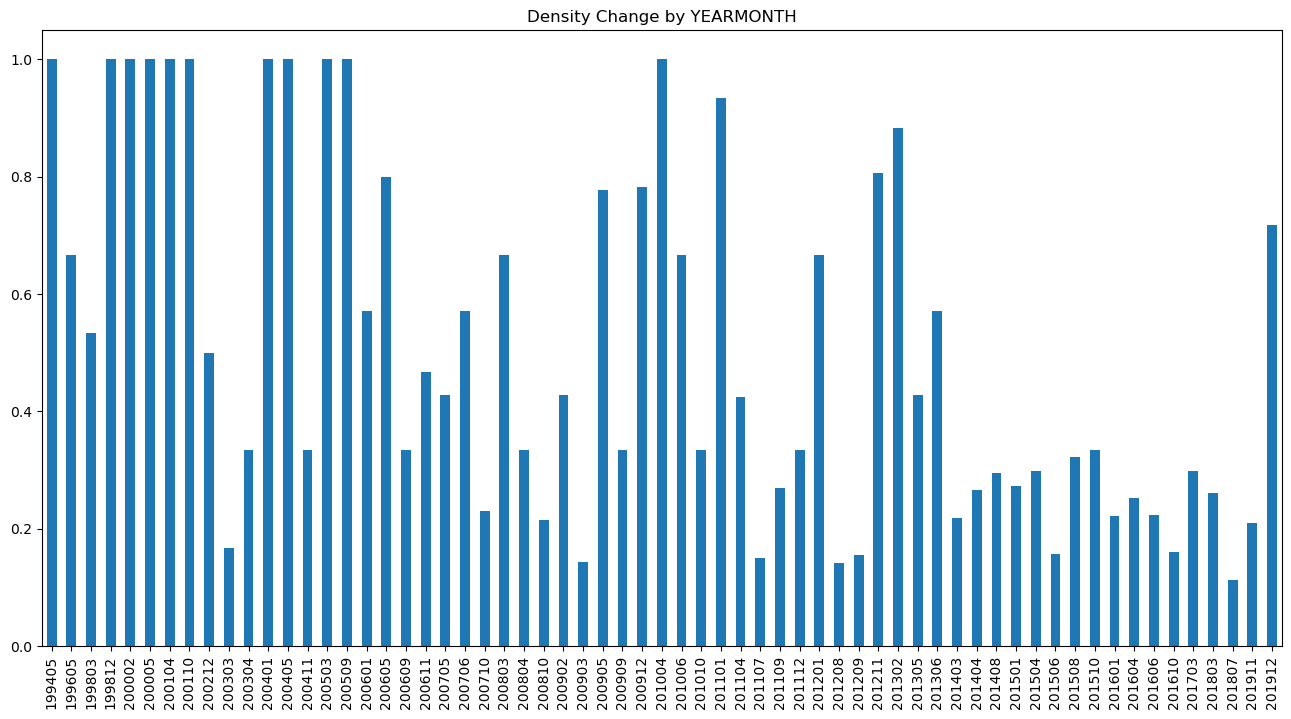

In [31]:
threshold = .1

result_df = result_df[result_df['density_change']>threshold]

title = 'Density Change by YEARMONTH'

_= result_df['density_change'].plot.bar(figsize=(16, 8), title=title)

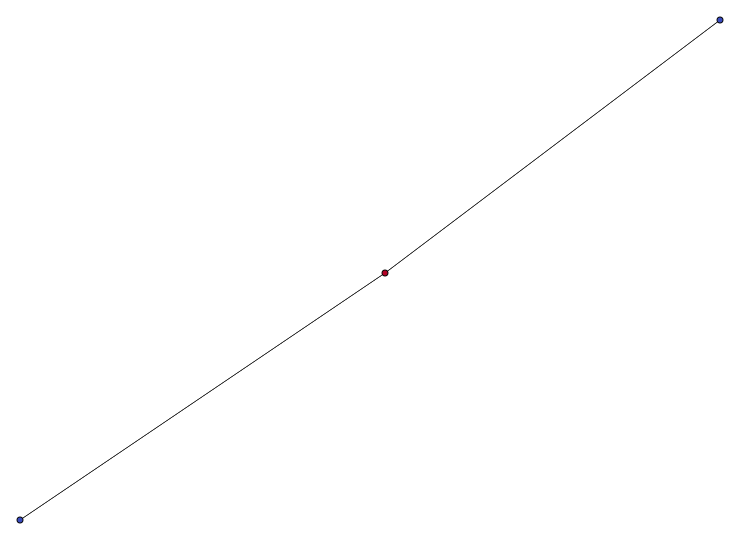

In [32]:
draw_graph(G['201104']['graph'], show_names=False, node_size=3)

# Burstiness By Density Decrease (EVERYBODY BOYCOTTED AND LEFT)

This can be done, too. But I will leave it for another day. Give it a try!

# Burstiness By Component Count

This can be done, too. But I will leave it for another day. Give it a try!